### Install Dependencies

In [122]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install scikit-learn
!pip install statsmodels


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\stavr\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\stavr\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\stavr\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\stavr\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\stavr\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


### Imports

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

### Read Data into pandas df

In [124]:
data = pd.read_csv('example_prices.csv', parse_dates=['dates'], index_col='dates')

In [125]:
# Extract the last 400 data points
last_400 = data.tail(400)

past = last_400.iloc[:200]  # First 210 points
last_20 = past.iloc[-20:]   # Last 20 points of past
future = last_400.iloc[199:210]  # Next 200 points (from index 190 onward)

## Trend Line (by regression) for the past 200 days

In [126]:

past.loc[:, 'time'] = (past.index - past.index[0]).days
last_20.loc[:, 'time'] = (last_20.index - last_20.index[0]).days

l = last_20[['time']]

X = past[['time']]  # Independent variable (time)
y = past['diamonds']  # Dependent variable (actual data)

# Fit a linear regression model
model = LinearRegression()
model.fit(X, y)

trend_line = model.predict(X)


C:\Users\stavr\AppData\Local\Temp\ipykernel_28524\854305453.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  past.loc[:, 'time'] = (past.index - past.index[0]).days
C:\Users\stavr\AppData\Local\Temp\ipykernel_28524\854305453.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_20.loc[:, 'time'] = (last_20.index - last_20.index[0]).days


## Find MAX and MIN for 200 to form belinger bounds

In [127]:
# Find the maximum point in past
if not past['diamonds'].dropna().empty:
    max_index = past['diamonds'].idxmax()
    max_time = (max_index - last_400.index[0]).days
    max_value = past.loc[max_index, 'diamonds']

    # Calculate the equation of the new line: y = slope * (x - max_time) + max_value
    slope = model.coef_[0]
    max_line = slope * (X['time'] - max_time) + max_value

# Find the minimum point in past
if not past['diamonds'].dropna().empty:
    min_index = past['diamonds'].dropna().idxmin()
    min_time = (min_index - last_400.index[0]).days
    min_value = past.loc[min_index, 'diamonds']

    # Calculate the equation of the new line: y = slope * (x - min_time_past) + min_value_past
    min_line_past = slope * (X['time'] - min_time) + min_value

## Do the same as above but for last 20 days

In [128]:
#TODO
# Find the maximum point in last_20
# Ensure last_20 has a time column
last_20['time'] = (last_20.index - last_20.index[0]).days

# Find the maximum point in last_20
if not last_20['diamonds'].dropna().empty:
    max_index_20 = last_20['diamonds'].idxmax()
    max_time_20 = (max_index_20 - last_20.index[0]).days  # FIXED
    max_value_20 = last_20.loc[max_index_20, 'diamonds']

    # Compute trend line from max point
    slope = model.coef_[0]
    max_line_20 = slope * (last_20['time'] - max_time_20) + max_value_20  # FIXED

# Find the minimum point in last_20
if not last_20['diamonds'].dropna().empty:
    min_index_20 = last_20['diamonds'].idxmin()
    min_time_20 = (min_index_20 - last_20.index[0]).days  # FIXED
    min_value_20 = last_20.loc[min_index_20, 'diamonds']

    # Compute trend line from min point
    min_line_20 = slope * (last_20['time'] - min_time_20) + min_value_20  # FIXED


C:\Users\stavr\AppData\Local\Temp\ipykernel_28524\4141029192.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_20['time'] = (last_20.index - last_20.index[0]).days


## Adjusting trend line based on last 20 days averages

In [129]:
weight = 20
intercept_shift = (-min_value_20 + max_value_20) / weight
trend_line_adjusted = model.predict(X) + intercept_shift

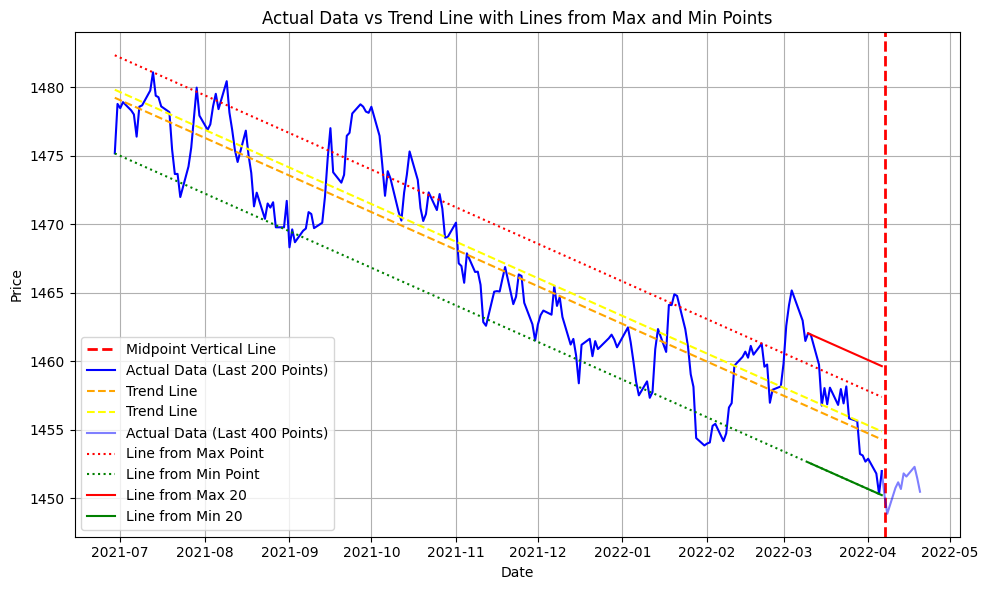

In [130]:
plt.figure(figsize=(10, 6))

# Plot a vertical line at the midpoint
x_mid = last_400.index[len(last_400) // 2]  # Middle point of the time index
plt.axvline(x=x_mid, color='red', linestyle='--', linewidth=2, label='Midpoint Vertical Line')


# Plot the actual data and trend line
plt.plot(past.index, y, label='Actual Data (Last 200 Points)', color='blue')


plt.plot(past.index, trend_line, label='Trend Line', color='orange', linestyle='--')
plt.plot(past.index, trend_line_adjusted, label='Trend Line', color='yellow', linestyle='--')


# Plot actual data over last_400
plt.plot(future.index, future['diamonds'], label='Actual Data (Last 400 Points)', color='blue', alpha=0.5)


# Plot the new lines if they were calculated
if 'max_line' in locals():
    plt.plot(past.index, max_line, label='Line from Max Point', color='red', linestyle=':')
if 'min_line_past' in locals():
    plt.plot(past.index, min_line_past, label='Line from Min Point', color='green', linestyle=':')

if 'max_line_20' in locals():
    plt.plot(last_20.index, max_line_20, label='Line from Max 20', color='red')
if 'min_line_20' in locals():
    plt.plot(last_20.index, min_line_20, label='Line from Min 20', color='green')

# Add labels, title, and legend
plt.title('Actual Data vs Trend Line with Lines from Max and Min Points')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
